In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
    
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm

import random, time

from torch.utils.tensorboard import SummaryWriter

from datasets import synthetic as load_datasets
from datasets import real as load_real_datasets
from datasets import real_only as load_only_real_datasets
from utils import plotter, visualizer

import metrics
from models import PVT, UNet, ResNet, ConvNext, ViT, SegFormer

import trainer as train_funct
from trainer import Trainer

/home/firp/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/firp/.local/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
writer = SummaryWriter()

In [3]:
train_funct.set_seed(42)

## Dataset

In [15]:
train_datapath = "Datasets/Training_set"
val_datapath = "Datasets/Validation_set"
test_datapath = "Datasets/Test_set"

In [5]:
train_data = load_datasets.SonarDescriptorDatasetFull(train_datapath, None)
val_data = load_datasets.SonarDescriptorDatasetFull(val_datapath, train_data)
test_data = load_datasets.SonarDescriptorDatasetFull(test_datapath, train_data)

In [6]:
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Training: 4000
Validation: 4000
Test: 4000


In [27]:
real_data = load_real_datasets.SonarDescriptorRealDataset(None, None)

In [28]:
print("Real: " + str(len(real_data.imgs)))

Real: 2182


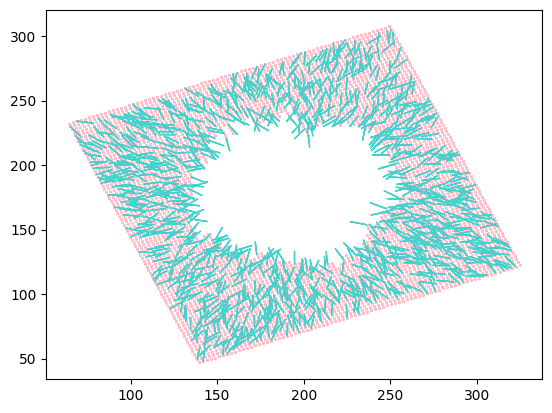

In [9]:
plotter.plot_train_data(train_data)

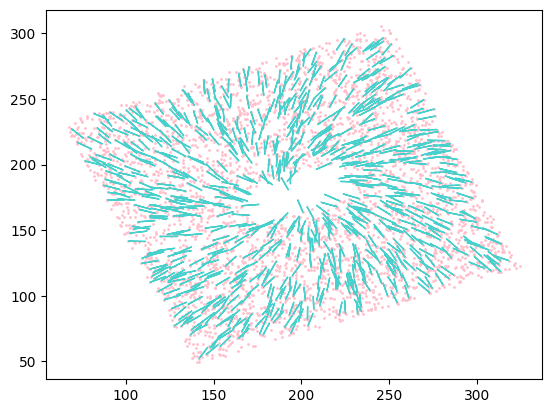

In [10]:
plotter.plot_data(val_data)

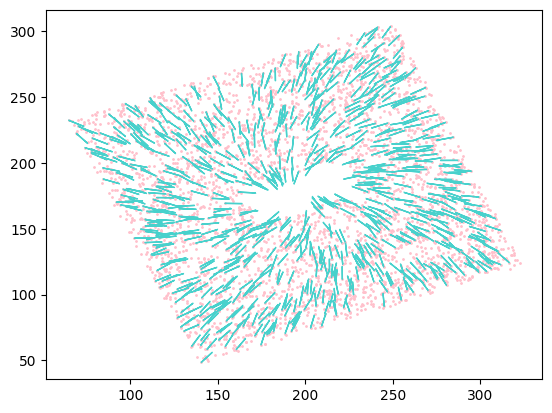

In [11]:
plotter.plot_data(test_data)

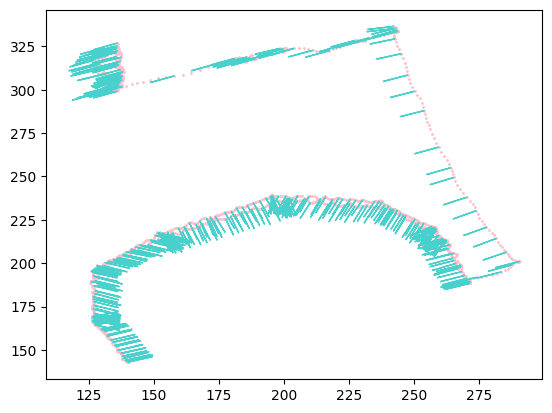

In [12]:
plotter.plot_data(real_data)

In [13]:
q_pose = real_data.poses[700]

q_x, q_y, q_Y_deg = q_pose
q_pose = np.array([q_x, q_y, (90+q_Y_deg)%360])

gt_pose_idx = train_data.gtquery(q_x, q_y, q_Y_deg)

Validation before filtering: 4000


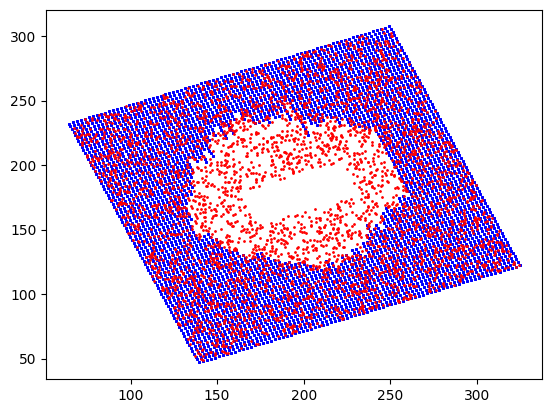

In [14]:
plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(val_data, "red")

print("Validation before filtering: " + str(len(val_data.imgs)))

Filtering validation poses: 100%|█████████| 4000/4000 [00:01<00:00, 2000.99it/s]


Validation after filtering: 3253


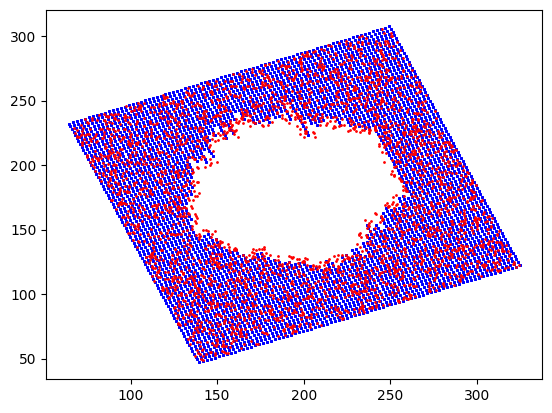

In [15]:
visualizer.filter_data(train_data, val_data)

plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(val_data, "red")

print("Validation after filtering: " + str(len(val_data.imgs)))

Test before filtering: 4000


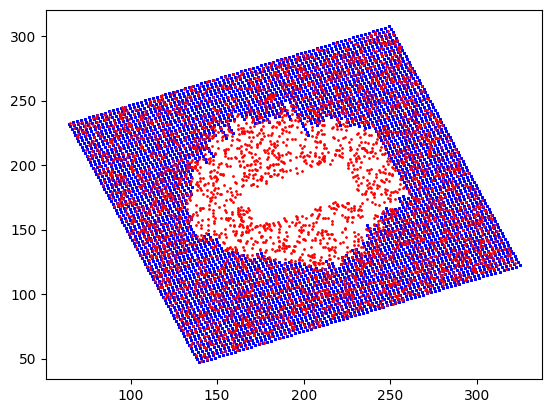

In [16]:
plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(test_data, "red")

print("Test before filtering: " + str(len(test_data.imgs)))

Filtering validation poses: 100%|█████████| 4000/4000 [00:02<00:00, 1998.12it/s]


Test after filtering: 3271


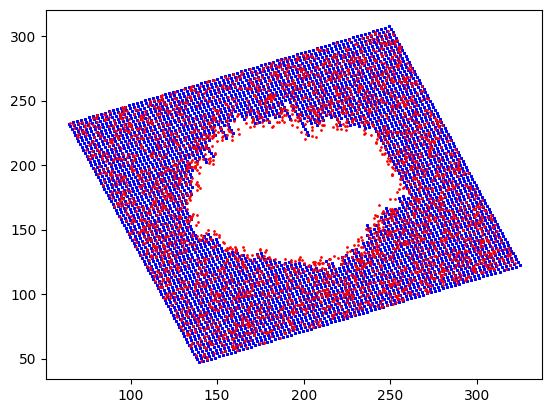

In [17]:
visualizer.filter_data(train_data, test_data)

plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(test_data, "red")

print("Test after filtering: " + str(len(test_data.imgs)))

iou: 0.9185888716281714
yaw difference tensor(7.2461) deg
localization error:  0.037775546 meters


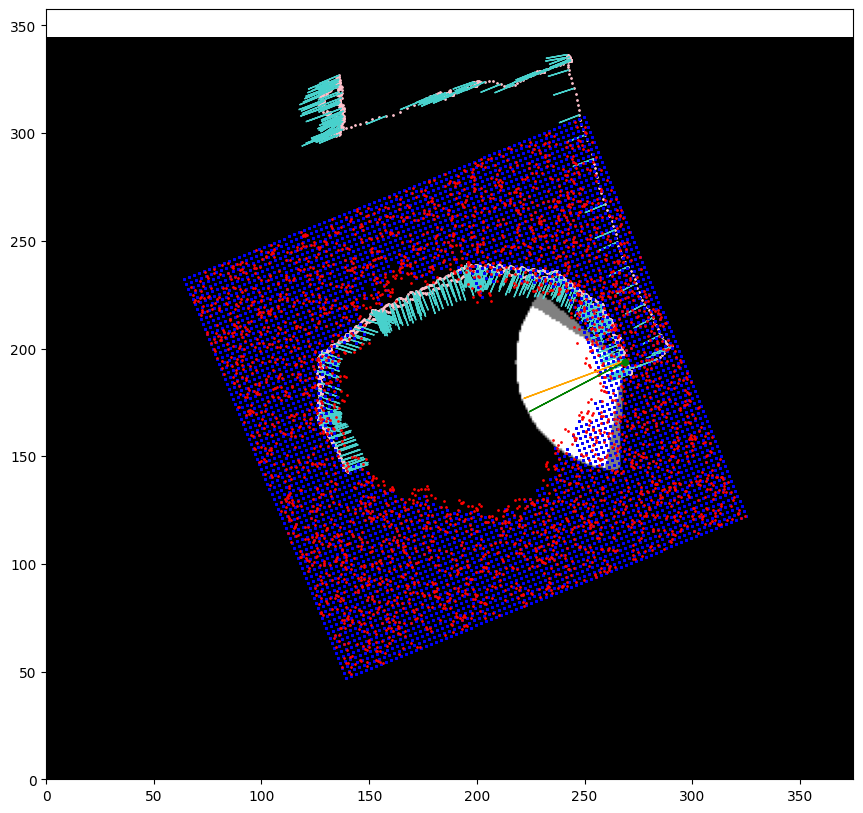

<Figure size 640x480 with 0 Axes>

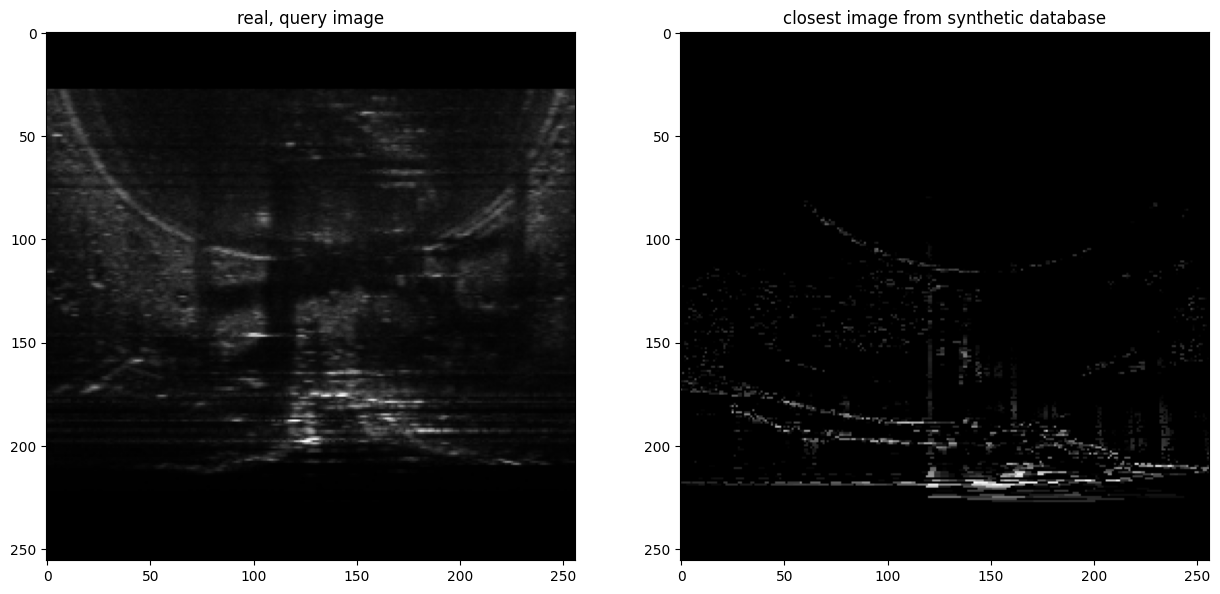

In [18]:
visualizer.localization(train_data, val_data, real_data)

In [19]:
print("Datasets before ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets before ground truth check
Training: 24005
Validation: 3253
Test: 3271


In [20]:
val_data = visualizer.check_gt(train_data, val_data)

In [21]:
test_data = visualizer.check_gt(train_data, test_data)

In [22]:
print("Datasets after ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets after ground truth check
Training: 24005
Validation: 3251
Test: 3267


In [7]:
model_name = "ViT"

In [8]:
batch = 16
train_dataloader = DataLoader(train_data, batch_size=batch, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch, shuffle=True)

## Model

### Model instantiation

In [9]:
net = ViT.Model().cuda()
net.train()

optimizer = torch.optim.AdamW(net.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=len(train_data), gamma=0.8)

drop = torch.nn.Dropout(0.3).cuda()

In [10]:
locacriterion = torch.nn.CrossEntropyLoss().cuda()
recocriterion = torch.nn.MSELoss().cuda()

In [11]:
total_params = metrics.count_parameters(net)
print("Total parameters: ", total_params)

Total parameters:  118920074


## Training Pipeline

### Train epochs

In [12]:
trainer = Trainer(writer, train_data, train_dataloader, val_data, val_dataloader, net, optimizer, scheduler, drop, recocriterion, locacriterion)
num_epochs = 12

start_train = time.time()
best_model_path = trainer.train(num_epochs)
end_train = time.time()

training_time = end_train - start_train
print("Training time: ", training_time, "seconds")

epoch: 1


100%|█████████████████████████████████████████| 250/250 [05:58<00:00,  1.43s/it]


train loss mean: 0.07148108103685082


100%|█████████████████████████████████████████| 250/250 [05:56<00:00,  1.43s/it]


val loss mean: 0.007254071531817317
computing dataset descriptors


100%|██████████████████████████████████████| 4000/4000 [00:16<00:00, 244.37it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 4000/4000 [00:16<00:00, 245.95it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 4000/4000 [02:08<00:00, 31.12it/s]


average localization error: 1.9425 meters
average orientation error : 20.9416 degrees
epoch: 2


100%|█████████████████████████████████████████| 250/250 [06:15<00:00,  1.50s/it]


train loss mean: 0.007336334088817239


100%|█████████████████████████████████████████| 250/250 [06:17<00:00,  1.51s/it]


val loss mean: 0.007276278806850314
computing dataset descriptors


100%|██████████████████████████████████████| 4000/4000 [00:16<00:00, 242.38it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 4000/4000 [00:16<00:00, 236.53it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 4000/4000 [02:10<00:00, 30.55it/s]


average localization error: 1.9012 meters
average orientation error : 20.5998 degrees
epoch: 3


100%|█████████████████████████████████████████| 250/250 [06:16<00:00,  1.51s/it]


train loss mean: 0.00732236947119236


 74%|██████████████████████████████▏          | 184/250 [04:37<01:39,  1.51s/it]


KeyboardInterrupt: 

In [ ]:
inference_time_per_image = metrics.inference_time(net, train_dataloader)
print("Inference time per image: ", inference_time_per_image, "seconds")

In [ ]:
metrics.get_descriptors(train_data, val_data, net)

## Visualize Training results on Test data

### Load the checkpoint model

In [58]:
checkpoint_path = best_model_path
print("Best model path: ", best_model_path)
#checkpoint_path = "correct_model_3/epoch_011.pth"
net = ViT.Model()
train_funct.load_state(net, checkpoint_path)

net = net.cuda()
net.eval();

### Compute the final descriptors of the training data

### Query the database

In [59]:
train_data.apply_random_rot = False
train_data.computeDescriptors(net)

computing dataset descriptors


  1%|▏                                       | 21/4000 [00:00<00:19, 202.60it/s]

input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch.Size([1, 64, 4])
shape output mlp dopo normalizzazione: torch.Size([1, 256])
input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch.Size([1, 64, 4])
shape output mlp dopo normalizzazione: torch.Size([1, 256])
input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch.Size([1, 64, 4])
shape output mlp dopo normalizzazione: torch.Size([1, 256])
input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch.Size([1, 64, 4])
shape output mlp dopo normalizzazione: torch.Size([1, 256])
input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
sha

  2%|▋                                       | 71/4000 [00:00<00:16, 232.26it/s]

input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch.Size([1, 64, 4])
shape output mlp dopo normalizzazione: torch.Size([1, 256])
input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch.Size([1, 64, 4])
shape output mlp dopo normalizzazione: torch.Size([1, 256])
input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch.Size([1, 64, 4])
shape output mlp dopo normalizzazione: torch.Size([1, 256])
input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch.Size([1, 64, 4])
shape output mlp dopo normalizzazione: torch.Size([1, 256])
input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
sha

  3%|█▏                                     | 128/4000 [00:00<00:14, 260.95it/s]

shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch.Size([1, 64, 4])
shape output mlp dopo normalizzazione: torch.Size([1, 256])
input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch.Size([1, 64, 4])
shape output mlp dopo normalizzazione: torch.Size([1, 256])
input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch.Size([1, 64, 4])
shape output mlp dopo normalizzazione: torch.Size([1, 256])
input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch.Size([1, 64, 4])
shape output mlp dopo normalizzazione: torch.Size([1, 256])
input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch

  5%|█▊                                     | 182/4000 [00:00<00:14, 264.02it/s]

shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch.Size([1, 64, 4])
shape output mlp dopo normalizzazione: torch.Size([1, 256])
input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch.Size([1, 64, 4])
shape output mlp dopo normalizzazione: torch.Size([1, 256])
input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch.Size([1, 64, 4])
shape output mlp dopo normalizzazione: torch.Size([1, 256])
input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch.Size([1, 64, 4])
shape output mlp dopo normalizzazione: torch.Size([1, 256])
input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch

  6%|██▎                                    | 240/4000 [00:00<00:13, 274.69it/s]

shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch.Size([1, 64, 4])
shape output mlp dopo normalizzazione: torch.Size([1, 256])
input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch.Size([1, 64, 4])
shape output mlp dopo normalizzazione: torch.Size([1, 256])
input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch.Size([1, 64, 4])
shape output mlp dopo normalizzazione: torch.Size([1, 256])
input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch.Size([1, 64, 4])
shape output mlp dopo normalizzazione: torch.Size([1, 256])
input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch

  7%|██▉                                    | 298/4000 [00:01<00:13, 278.21it/s]

shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch.Size([1, 64, 4])
shape output mlp dopo normalizzazione: torch.Size([1, 256])
input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch.Size([1, 64, 4])
shape output mlp dopo normalizzazione: torch.Size([1, 256])
input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch.Size([1, 64, 4])
shape output mlp dopo normalizzazione: torch.Size([1, 256])
input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch.Size([1, 64, 4])
shape output mlp dopo normalizzazione: torch.Size([1, 256])
input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch

  9%|███▌                                   | 363/4000 [00:01<00:13, 265.41it/s]

input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch.Size([1, 64, 4])
shape output mlp dopo normalizzazione: torch.Size([1, 256])
input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch.Size([1, 64, 4])
shape output mlp dopo normalizzazione: torch.Size([1, 256])
input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch.Size([1, 64, 4])
shape output mlp dopo normalizzazione: torch.Size([1, 256])
input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
shape output mlp prima normalizzazione: torch.Size([1, 64, 4])
shape output mlp dopo normalizzazione: torch.Size([1, 256])
input shape: torch.Size([1, 2, 256, 256])
shape feature map dopo encoder: torch.Size([1, 512, 8, 8])
sha

KeyboardInterrupt: 

### Visualize query results: sonar images

In [19]:
import pickle

with open("train_data.pickle", "wb") as handle:
    pickle.dump(train_data, handle)

torch.Size([1, 256, 2, 2]) tensor(-1.7209, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.5921, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 256, 4, 4]) tensor(-1.4734, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.5056, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 256, 16, 16]) tensor(-1.9610, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.8644, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 256, 8, 8]) tensor(-2.2539, device='cuda:0', grad_fn=<MinBackward1>) tensor(2.1392, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.5987, device='cuda:0', grad_fn=<MinBackward1>) tensor(-0.3582, device='cuda:0', grad_fn=<MaxBackward1>)


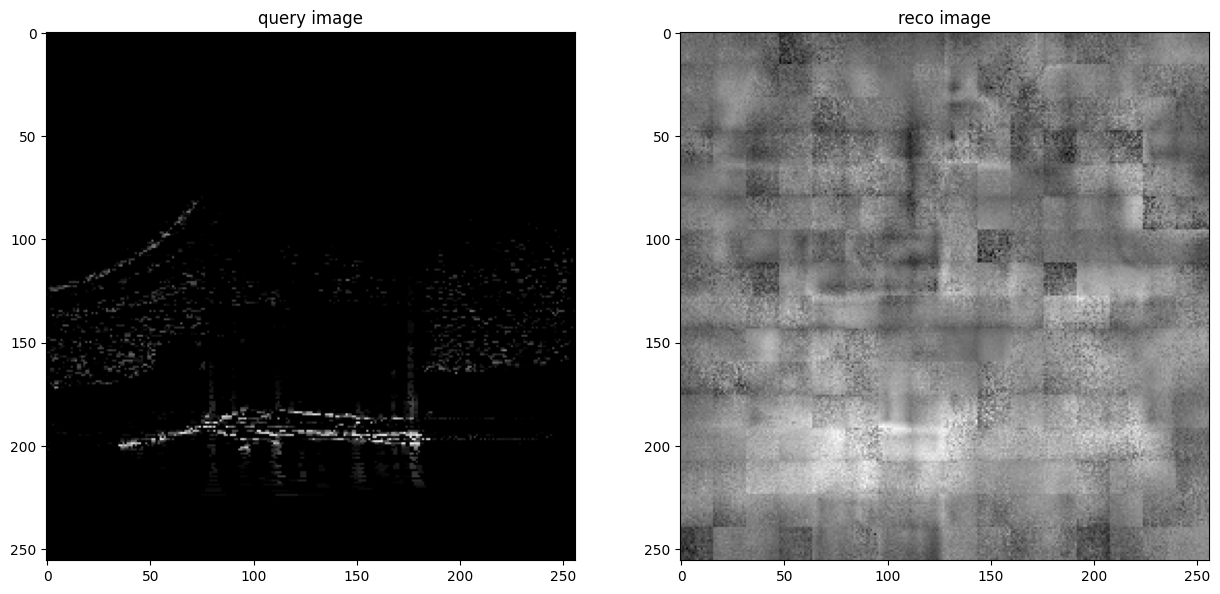

In [20]:
visualizer.analyze_feature_robustness(train_data, net)

iou: 0.9999999999999901
localization error: 0.0000 meters
orientation error : 0.0000 degrees


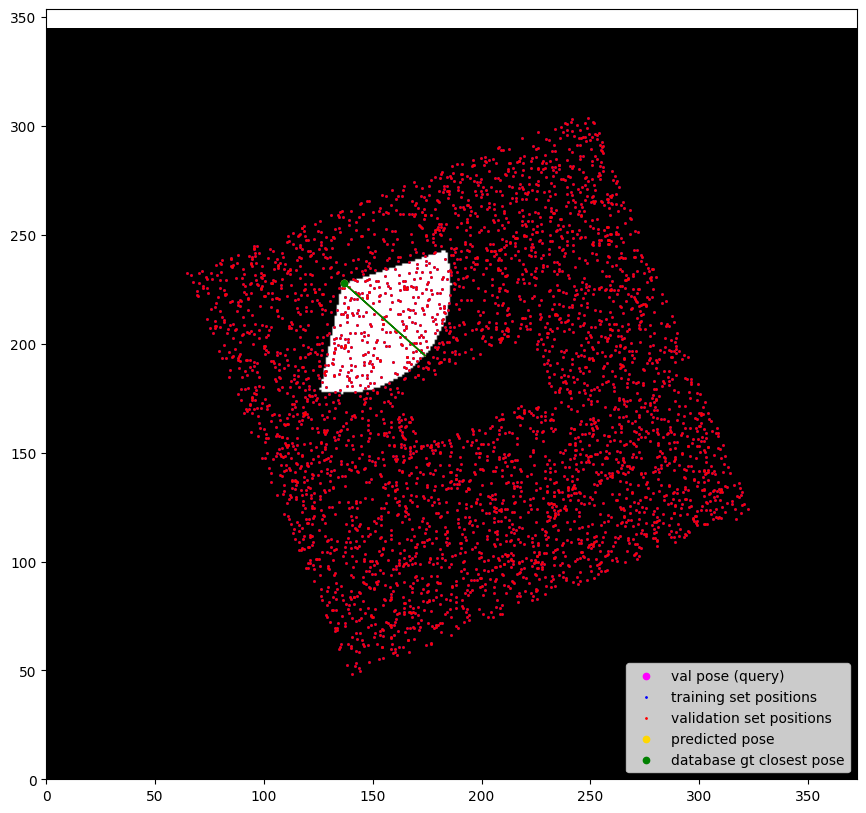

<Figure size 640x480 with 0 Axes>

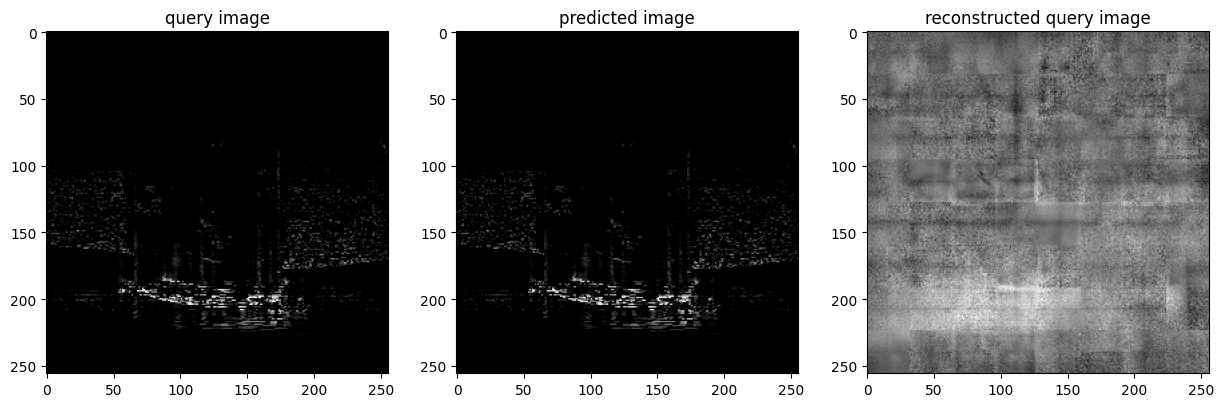

In [21]:
query_idx = random.randint(0, len(test_data))

loca_error, orie_error = visualizer.process(query_idx, net, train_data, test_data, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [22]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(test_data))):
    loca_error, orie_error = visualizer.process(query_idx, net, train_data, test_data, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.array(orie_errors).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

ale_t = avg_loca_error
aoe_t = avg_orie_error

100%|███████████████████████████████████████| 4000/4000 [02:14<00:00, 29.70it/s]

average localization error: 0.0000 meters
average orientation error : 0.0000 degrees


In [23]:
loca_errors = np.array(loca_errors)
orie_errors = np.array(orie_errors)

In [24]:
loca_errors.argmax()

np.int64(0)

In [25]:
le = loca_errors[loca_errors<10]
oe = orie_errors[orie_errors<10]
print(le.mean())
print(oe.mean())

0.0
0.0


## Process real images

query_idx: 250
input shape: torch.Size([1, 2, 256, 256])
input shape after interpolate: torch.Size([1, 2, 256, 256])
223.59009 233.76007 2.7737005 -21.078674
iou: 0.1977742721303029
localization error Upper:  6.971907 meters


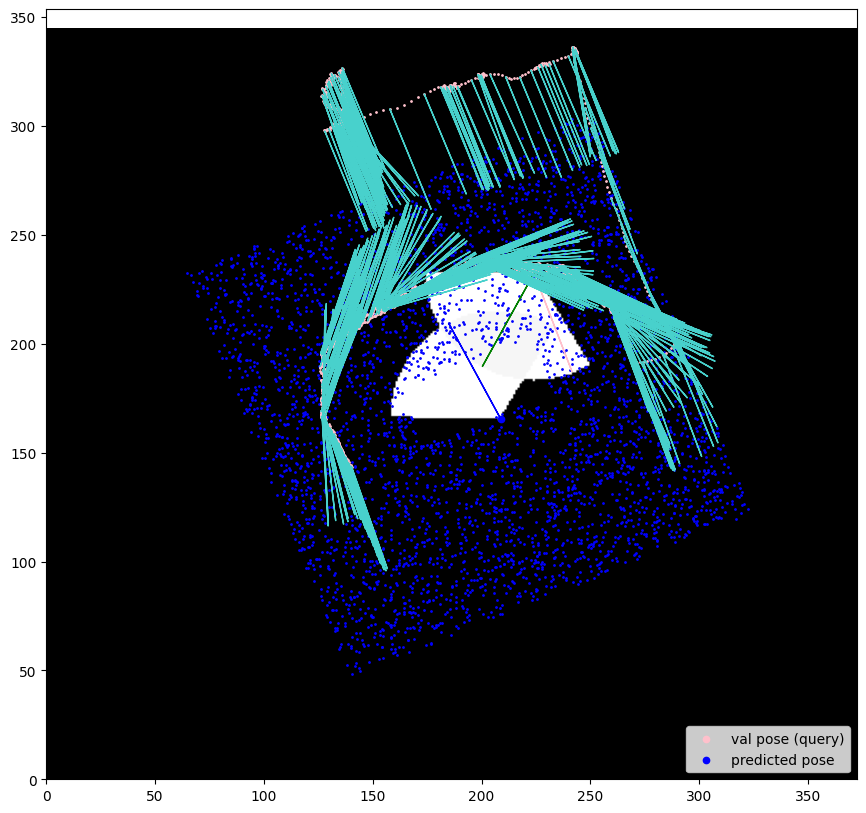

<Figure size 640x480 with 0 Axes>

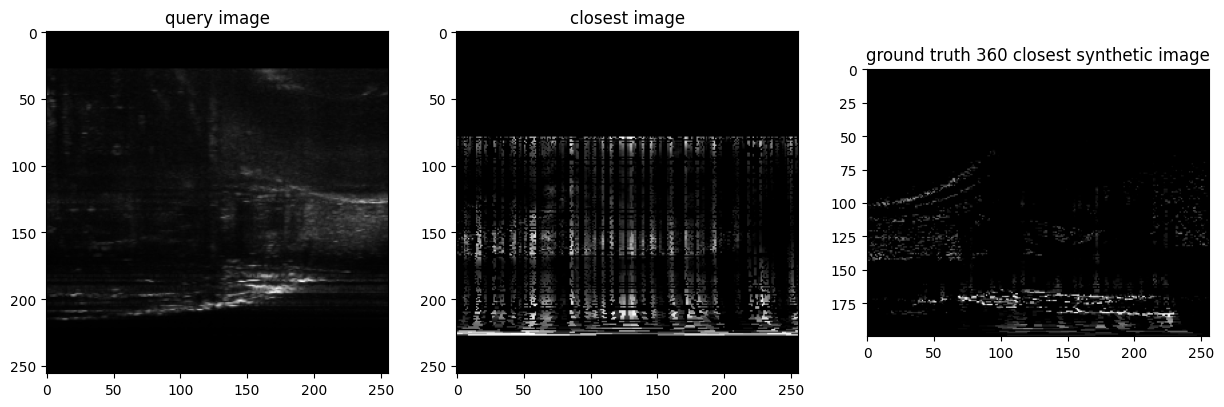

In [36]:
query_idx = random.randint(0, 600)
train_data.apply_random_rot = True
train_data.training = True
print("query_idx:", query_idx)
visualizer.process_real(query_idx, net, train_data, real_data)

## Process ONLY real images

In [30]:
real_data_train = load_only_real_datasets.SonarDescriptorOnlyRealDataset()
real_data_valid = load_only_real_datasets.SonarDescriptorOnlyRealDataset(real_data_train)

In [60]:
real_data_train.computeDescriptors(net)

computing dataset descriptors


  0%|                                                   | 0/710 [00:00<?, ?it/s]

input shape: torch.Size([1, 2, 276, 256])
shape feature map dopo encoder: torch.Size([1, 512, 9, 8])


RuntimeError: running_mean should contain 72 elements not 64

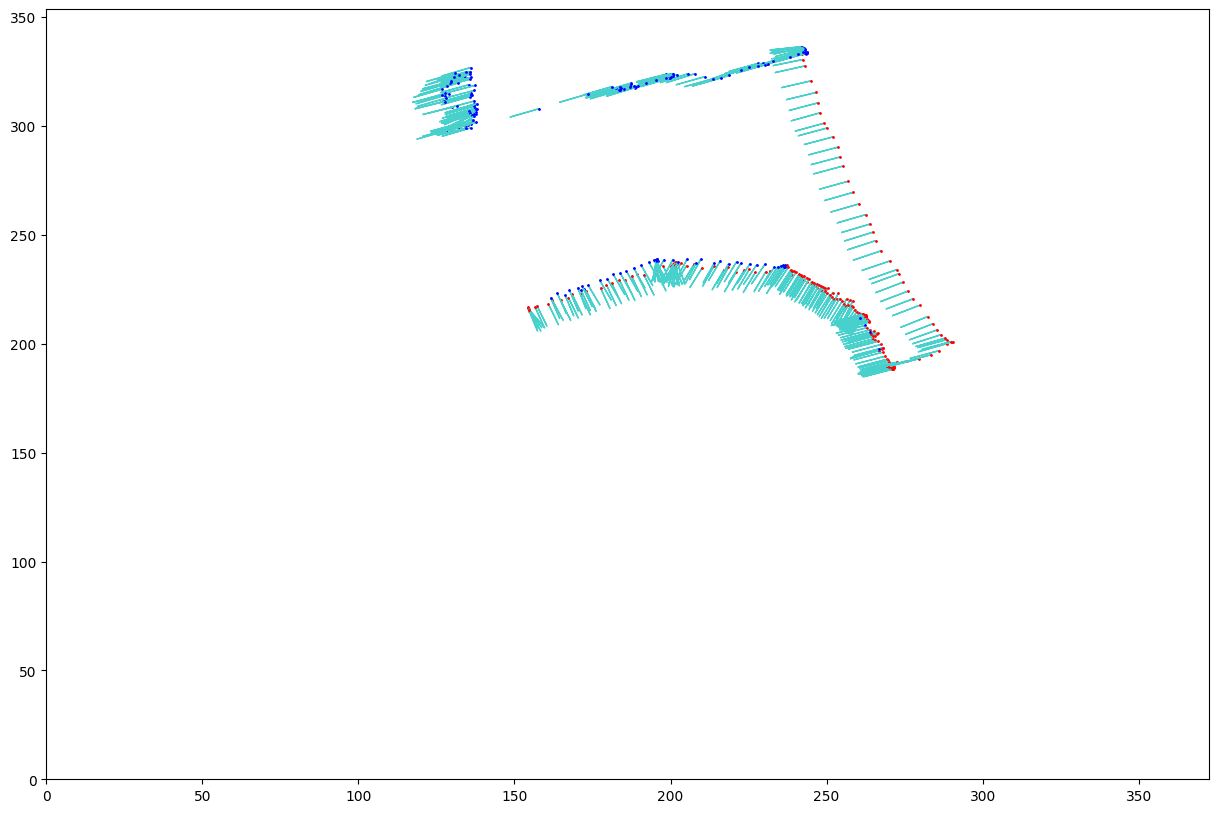

In [33]:
visualizer.visualize_real(train_data, real_data)

iou: 0.7954878608423351
localization error: 1.1780 meters
orientation error : 42.9260 degrees


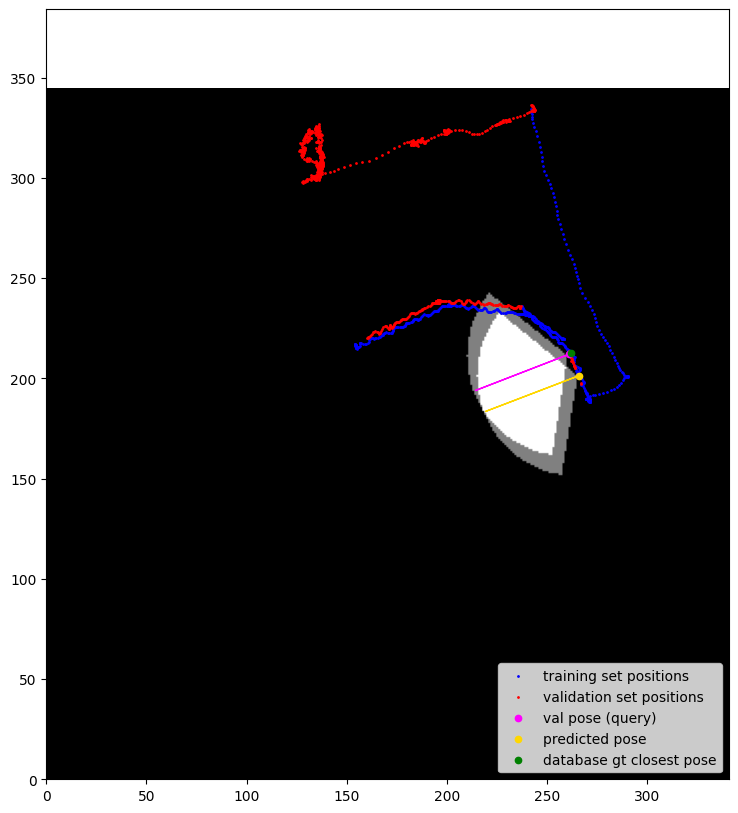

<Figure size 640x480 with 0 Axes>

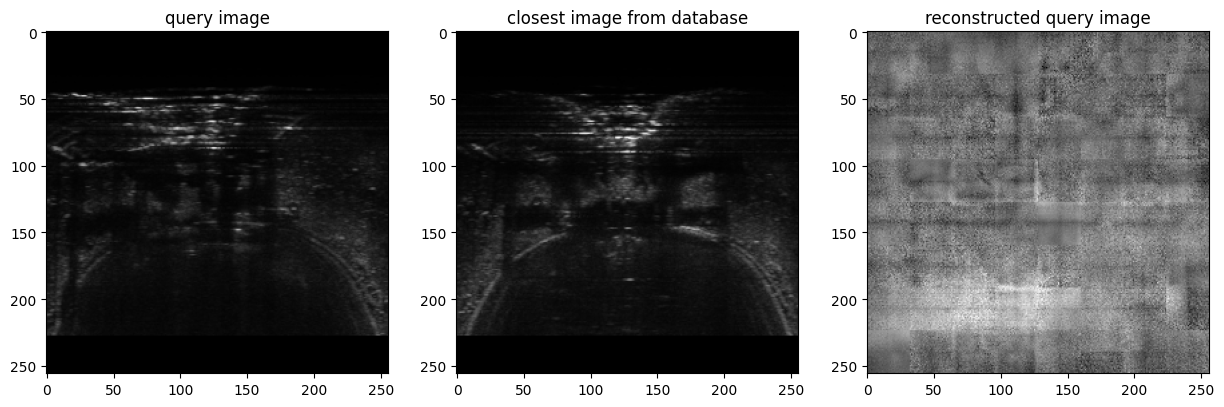

In [34]:
query_idx = random.randint(700, len(real_data_valid))
loca_error, orie_error = visualizer.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [35]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(real_data_valid))):
    loca_error, orie_error = visualizer.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.abs(np.array(orie_errors)).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

ale_r = avg_loca_error
aoe_r = avg_orie_error

100%|█████████████████████████████████████████| 785/785 [00:15<00:00, 51.26it/s]

average localization error: 5.5689 meters
average orientation error : 41.3715 degrees


In [ ]:
avg_orie_error.min()

## Results

In [ ]:
file_path = "results.csv"
metrics.save_results(model_name, total_params, training_time, inference_time_per_image, ale_t, aoe_t, ale_r, aoe_r, file_path)

print(f"Model name: {model_name}")
print(f"Total parameters: {total_params}")
print(f"Training time: {training_time:6.4f} seconds")
print(f"Inference time per image: {inference_time_per_image:6.4f} seconds")
print(f"Average localization error in Test: {ale_t:6.4f} meters")
print(f"Average orientation error in Test: {aoe_t:6.4f} degrees")
print(f"Average localization error in Real: {ale_r:6.4f} meters")
print(f"Average orientation error in Real: {aoe_r:6.4f} degrees")